# Analysis of the _Sampson's Monks_ dataset

In [1]:
import pickle
import gzip
from pathlib import Path
from datetime import date
from dateutil.relativedelta import relativedelta
import json
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score as ami

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.3,
    palette="deep"
)

RED    = "#C52D25"
BLUE   = "#047DB7"
GRAY   = "#efefef"
# COLORS = np.array(["#f97959", "#7aa063", "#60a1f7"])
COLORS = np.array(["#c76674", "#9a9945", "#8961b3"])

# Paths
HERE = Path(".").absolute()
ROOT = HERE.parent.parent
DATA = ROOT/"data"/"congress"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

with gzip.open("./data.pkl.gz", "rb") as fh:
    data, stats = pickle.load(fh)


In [2]:
## US CONGRESS DATES (from: https://en.wikipedia.org/wiki/List_of_United_States_Congresses)
DATES = {
    (n+93): (date(1973+n*2, 1, 3), date(1974+n*2, 1, 3), date(1975+n*2, 1, 3))
    for n in range(len(data.loc[data["chamber"] == "H"]))
}
## US PRESIDENTS (from: https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States)
with open(DATA/"presidents.json", "r") as fh:
    PRESIDENTS = json.loads(fh.read())

PRESDF = pd.DataFrame(PRESIDENTS)[["name", "midname", "surname", "affil", "start", "end"]] \
    .assign(
        start=lambda df: pd.to_datetime(df["start"]),
        end=lambda df: pd.to_datetime(df["end"])
    )


In [3]:
## MAKE TABLE
cols = ["f_rep", "f_dem", "n_nodes", "n_edges", "f_pos", "dobs", "dobw", "dbar", "dcv"]
ltx = pd.concat([
    stats.loc[chamber, cols] for chamber in stats.index.get_level_values("chamber").unique()
], axis=1, keys=["House", "Senate"], names=["chamber"]) \
    .stack(level="chamber") \
    .swaplevel() \
    .loc[["House", "Senate"], cols] \
    .style.format(precision=2) \
    .to_latex()

# print(ltx)


## Time series

In [4]:
pkws = dict(markersize=10, markeredgecolor="black")
date0 = data["start"].min() - relativedelta(years=1)

def mark_presidents(ax, show_names=True):
    formatter = mdates.DateFormatter("%Y")
    ax.xaxis.set_major_formatter(formatter)
    ticks = PRESDF["start"]
    ax.set_xticks(ticks)
    ax.xaxis.set_tick_params(labelsize=12)

    ax.set_xlim(date0, data["end"].max())
    ax.grid(False)
    for _, row in PRESDF.iterrows():
        color = RED if row["affil"] == "Republican" else BLUE
        ax.fill_between(row[["start", "end"]], -100, 400, color=color, alpha=.1, linewidth=0)
        name  = row["surname"]
        start = row["start"].date()
        x     = max(date0, start  + relativedelta(months=2))
        y     = .95#if ax is axes[0] else .55

        if show_names:
            ax.text(x, y, name, size=12)
        if start > date0:
            ax.axvline(start, ls="--", color="gray", linewidth=1, zorder=1)

def make_second_yaxis(ax, df, show=False):
    ax = ax.twinx()
    ax.grid(False)
    x = df["mid"]
    y = df["fbip"]
    c = RED if show else "white"
    if show:
        ax.plot(
            x, y, color=c, linewidth=4, zorder=6, marker="s", ls="--",
            markerfacecolor="white", **{**pkws, "markeredgecolor": RED },
            label="Percent of nodes in two largest clusters"
        )
    ax.set_ylim(-.05, 1.05)
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    ax.yaxis.label.set_color(c)
    ax.tick_params(axis="y", colors=c)
    return ax


### DoB

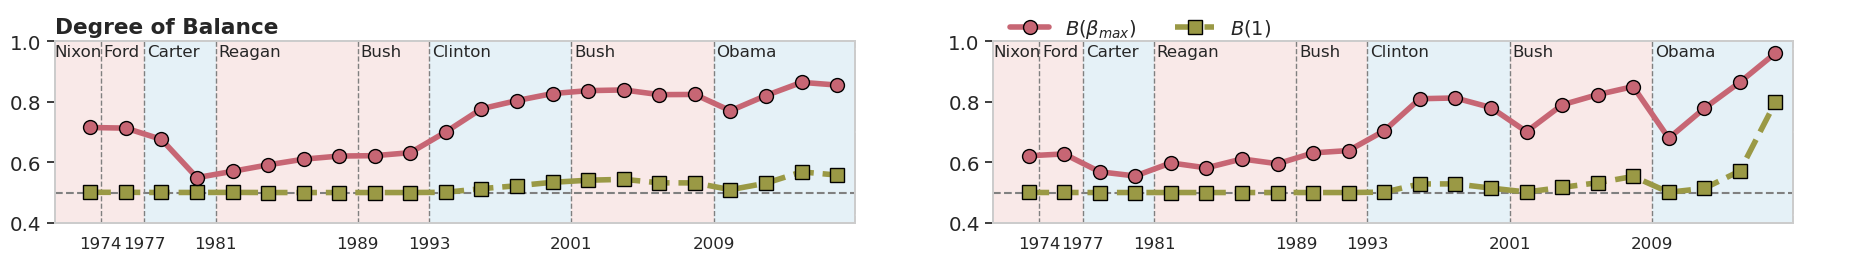

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19, 3))

for ax, chamber in zip(axes, ["H", "S"]):
    title = "House" if chamber == "H" else "Senate"
    df = data.set_index("chamber").loc[chamber]
    ax.axhline(.5, ls="--", color="gray")
    x  = df["mid"]
    y  = df["dobs"]
    c  = COLORS[0]
    ax.plot(
        x, y, color=c, linewidth=4, marker="o", zorder=11, **pkws,
        label=r"$B(\beta_{max})$"
    )
    y = df["dobs1"]
    c = COLORS[1]
    ax.plot(
        x, y, color=c, linewidth=4, ls="--", marker="s", zorder=10, **pkws,
        label=r"$B(1)$"
    )
    ax.get_xaxis().set_ticklabels([])
    ax.set_ylim(.4, 1)
    if chamber == "H":
        ax.set_title("Degree of Balance", fontweight="bold", ha="left", x=0)
    else:
        ax.legend(
            loc="upper left", ncol=3, frameon=False,
            fontsize=14, bbox_to_anchor=(0, 1.23)
        )
    mark_presidents(ax, show_names=True)
    make_second_yaxis(ax, df, show=False)

fig.tight_layout()
fig.savefig(FIGS/"congress-dob.pdf", bbox_inches="tight")


### Frustration ratio

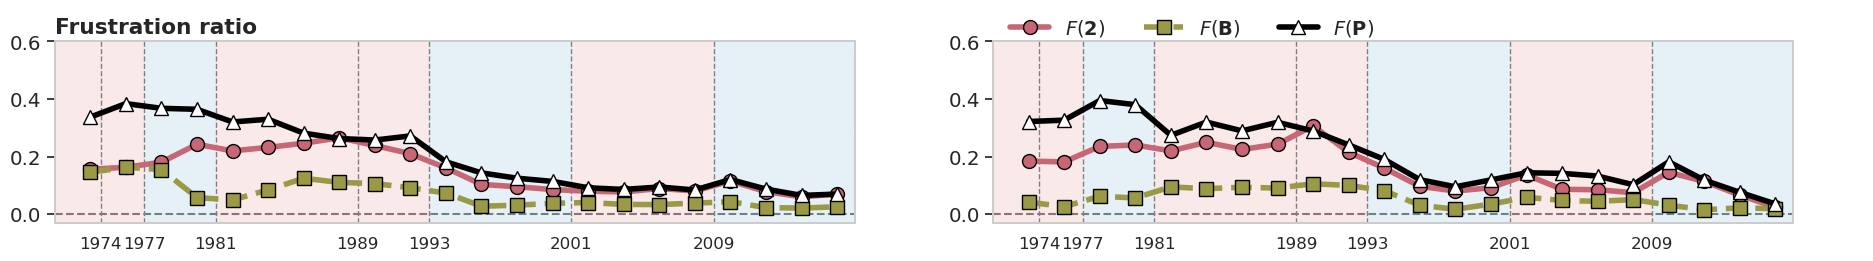

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19, 3))

for ax, chamber in zip(axes, ["H", "S"]):
    title = "House" if chamber == "H" else "Senate"
    df = data.set_index("chamber").loc[chamber]
    x  = df["mid"]
    y  = df["fidx2"]
    c  = COLORS[0]
    ax.plot(
        x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
        label=r"$F(\mathbf{2})$"
    )
    y  = df["fidx"]
    c  = COLORS[1]
    ax.plot(
        x, y, color=c, linewidth=4, ls="--", zorder=5, marker="s", **pkws,
        label=r"$F(\mathbf{B})$"
    )
    y = df["fidxp"]
    c = "black"
    ax.plot(
        x, y, color=c, linewidth=4, zorder=5, marker="^", **pkws,
        markerfacecolor="white",
        label=r"$F(\mathbf{P})$"
    )
    ax.set_ylim(-.03, .6)
    ax.axhline(0, ls="--", color="gray", zorder=1)
    ax.get_xaxis().set_ticklabels([])
    if chamber == "H":
        ax.set_title("Frustration ratio", fontweight="bold", ha="left", x=0)
    else:
        ax.legend(
            loc="upper left", ncol=3, frameon=False,
            fontsize=14, bbox_to_anchor=(0, 1.23)
        )
    mark_presidents(ax, show_names=False)
    make_second_yaxis(ax, df, show=False)

fig.tight_layout()
fig.savefig(FIGS/"congress-frustration.pdf", bbox_inches="tight")


### Clusterings and party structure

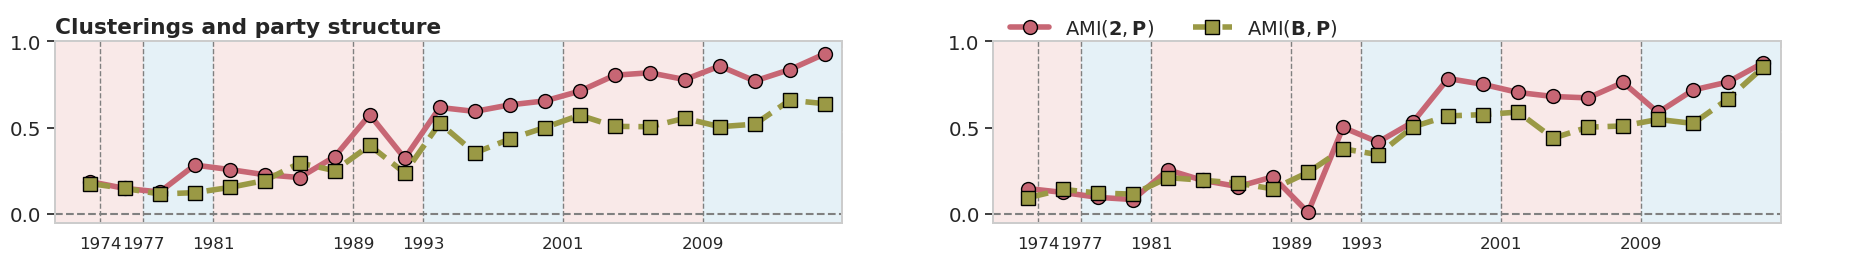

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19, 3))

for ax, chamber in zip(axes, ["H", "S"]):
    title = "House" if chamber == "H" else "Senate"
    df = data.set_index("chamber").loc[chamber]
    x  = df["mid"]
    y  = df["amip2"]
    c  = COLORS[0]
    ax.plot(
        x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
        label=r"AMI($\mathbf{2}, \mathbf{P}$)"
    )
    y  = df["amip"]
    c  = COLORS[1]
    ax.plot(
        x, y, color=c, linewidth=4, zorder=5, marker="s", ls="--", **pkws,
        label=r"AMI($\mathbf{B}, \mathbf{P}$)"
    )
    ax.set_ylim(-.05, 1)
    ax.axhline(0, ls="--", color="gray")
    ax.get_xaxis().set_ticklabels([])
    if chamber == "H":
        ax.set_title(
            "Clusterings and party structure",
            fontweight="bold", ha="left", x=0
        )
    else:
        ax.legend(
            loc="upper left", ncol=3, frameon=False,
            fontsize=14, bbox_to_anchor=(0, 1.23)
        )
    mark_presidents(ax, show_names=False)
    make_second_yaxis(ax, df, show=False)

fig.tight_layout()
fig.savefig(FIGS/"congress-clusterings.pdf", bbox_inches="tight")


### Clustering structure

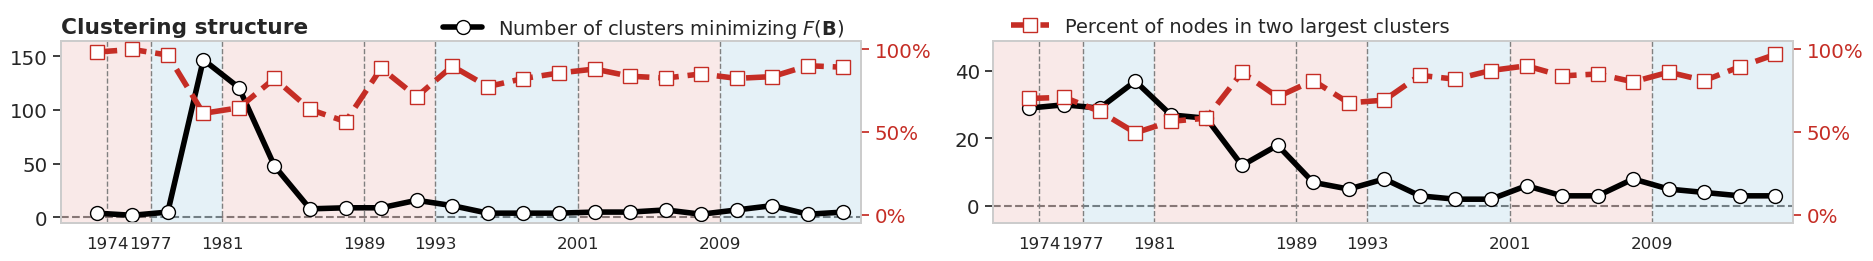

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19, 3))

for ax, chamber in zip(axes, ["H", "S"]):
    title = "House" if chamber == "H" else "Senate"
    df = data.set_index("chamber").loc[chamber]
    x  = df["mid"]
    y  = df["n"]
    c  = "black"
    ax.plot(
        x, y, color=c, linewidth=4, zorder=5, marker="o", **pkws,
        markerfacecolor="white",
        label=r"Number of clusters minimizing $F(\mathbf{B})$"
    )
    ax.axhline(0, ls="--", color="gray", zorder=1)
    _, y1 = ax.get_ylim()
    ax.set_ylim(-5, y1+10)
    mark_presidents(ax, show_names=False)
    ax2 = make_second_yaxis(ax, df, show=True)
    if chamber == "H":
        ax.set_title(
            "Clustering structure",
            fontweight="bold", ha="left", x=0
        )
        ax.legend(
            loc="upper right", ncol=1, frameon=False,
            fontsize=14, bbox_to_anchor=(1, 1.23)
        )
    else:
        ax2.legend(
            loc="upper left", ncol=1, frameon=False,
            fontsize=14, bbox_to_anchor=(0, 1.23)
        )

fig.tight_layout()
fig.savefig(FIGS/"congress-structure.pdf", bbox_inches="tight")


## Visualization of sample networks

Below we visualize Senate co-sponsorship networks from late Carter
administration (96th Congress, 1979, low polarization) and late Obama
administration (114th Congress, 2015, high polarization).

In [9]:
CMAP = {
    "R": "#D81F29",
    "D": "#00AEF3",
    "O": "gray"
}
SMAP = {
    "R": "s",
    "D": "o",
    "O": "^"
}
PARTIES = {
    "R": "Republican",
    "D": "Democrat",
    "O": "Other"
}

G1 = ig.Graph.Read_GraphMLz(DATA/"S96.graphml.gz")
G2 = ig.Graph.Read_GraphMLz(DATA/"S114.graphml.gz")
DATES[96]


(datetime.date(1979, 1, 3),
 datetime.date(1980, 1, 3),
 datetime.date(1981, 1, 3))

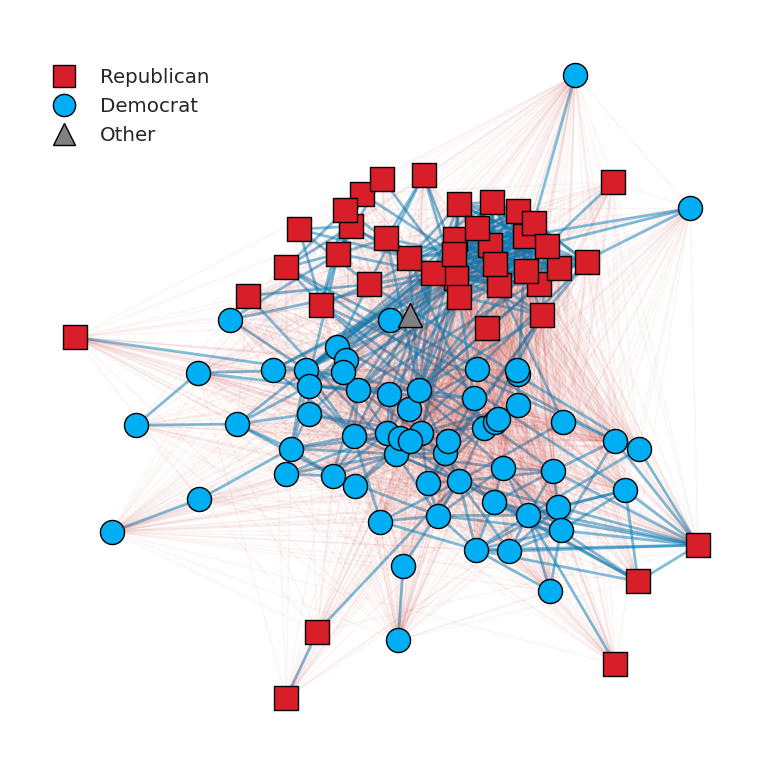

In [10]:
import random
random.seed(303)

fig, ax = plt.subplots(figsize=(8, 8))

G = G1
congress = G["congress"]
party = np.array(G.vs["party"])
party = np.where(np.isin(party, ["R", "D"]), party, "O")
pidx  = pd.Categorical(party).codes

Gp = G.copy()
Gp.es.select(weight_lt=0).delete()
weights = np.array(Gp.es["weight"])
vc = ig.VertexClustering(Gp, membership=pidx)
Gp.es["weight"] = np.where(vc.crossing(), 2*weights, weights)
pos = nx.kamada_kawai_layout(Gp.to_networkx())
N = G.to_networkx()
kwds = dict(G=N, pos=pos, ax=ax)

ecolors = [ RED if e["weight"] < 0 else BLUE for e in N.edges.values() ]
ealphas = [ .05 if e["weight"] < 0 else .5 for e in N.edges.values() ]
ewidths = [ 1 if e["weight"] < 0 else 2 for e in N.edges.values() ]
nx.draw_networkx_edges(**kwds, edge_color=ecolors, alpha=ealphas, width=ewidths)

x, y = np.stack(list(pos.values())).T
for p, gdf in pd.DataFrame({"x": x, "y": y}).groupby(party):
    color = CMAP[p]
    shape = SMAP[p]
    ax.scatter(
        gdf["x"], gdf["y"],
        color=color, edgecolors="black", s=300, marker=shape
    )
ax.axis("off")

handles = [
    mpl.lines.Line2D(
        [0], [0], color=CMAP[p], lw=0, label=PARTIES[p],
        marker=SMAP[p], markersize=16, markeredgecolor="black"
    ) for p in PARTIES
]
fig.legend(
    handles=handles, loc="center left", ncol=1,
    frameon=False, bbox_to_anchor=(.05, .85)
)

fig.tight_layout()
fig.savefig(FIGS/"congress-examples-1.pdf", bbox_inches="tight")


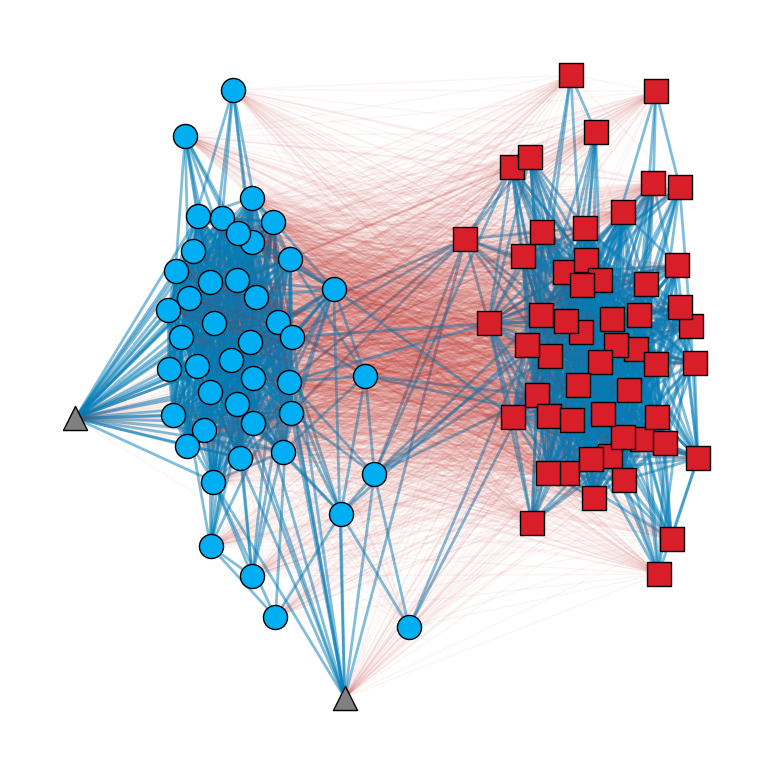

In [11]:
import random
random.seed(303)

fig, ax = plt.subplots(figsize=(8, 8))

G = G2
congress = G["congress"]
party = np.array(G.vs["party"])
party = np.where(np.isin(party, ["R", "D"]), party, "O")
pidx  = pd.Categorical(party).codes

Gp = G.copy()
Gp.es.select(weight_lt=0).delete()
weights = np.array(Gp.es["weight"])
vc = ig.VertexClustering(Gp, membership=pidx)
Gp.es["weight"] = np.where(vc.crossing(), 2*weights, weights)
pos = nx.kamada_kawai_layout(Gp.to_networkx())
N = G.to_networkx()
kwds = dict(G=N, pos=pos, ax=ax)

ecolors = [ RED if e["weight"] < 0 else BLUE for e in N.edges.values() ]
ealphas = [ .05 if e["weight"] < 0 else .5 for e in N.edges.values() ]
ewidths = [ 1 if e["weight"] < 0 else 2 for e in N.edges.values() ]
nx.draw_networkx_edges(**kwds, edge_color=ecolors, alpha=ealphas, width=ewidths)

x, y = np.stack(list(pos.values())).T
for p, gdf in pd.DataFrame({"x": x, "y": y}).groupby(party):
    color = CMAP[p]
    shape = SMAP[p]
    ax.scatter(
        gdf["x"], gdf["y"],
        color=color, edgecolors="black", s=300, marker=shape
    )
ax.axis("off")

fig.tight_layout()
fig.savefig(FIGS/"congress-examples-2.pdf", bbox_inches="tight")
